In [1]:
import yfinance as yf
import pandas as pd
import datetime
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pandas_datareader import data
from dask.distributed import Client
from dask.distributed import as_completed
import openpyxl
import xlsxwriter
import pandas_datareader.data as web
import statsmodels.tsa.stattools as ts
from numpy import cumsum, log, polyfit, sqrt, std, subtract
import pandas_market_calendars as mcal
import os
import sqlite3

In [2]:
end_ = datetime.today()
#start = end - relativedelta(years=2) - relativedelta(days=3)
start_ = end_ - relativedelta(months=64)
start_X2_ = end_ - relativedelta(months=64*2)

nyse = mcal.get_calendar('NYSE')
nyse_dates = nyse.schedule(start_date=start_, end_date=end_)

nyse_X2 = mcal.get_calendar('NYSE')
nyse_dates_X2 = nyse.schedule(start_date=start_X2_, end_date=end_)

start = nyse_dates.index[0]
start_X2 = nyse_dates_X2.index[0]

end = nyse_dates.index[-1]
print(start.strftime('%Y-%m-%d'))
print(end.strftime('%Y-%m-%d'))

2017-03-16
2022-07-15


In [3]:
"""
db_filename = '.\\data\\interim\\todo.db'

db_is_new = not os.path.exists(db_filename)

conn = sqlite3.connect(db_filename)

if db_is_new:
    print('Need to create schema')
else:
    print('Database exists, assume schema does, too.')

conn.close()
"""

"\ndb_filename = '.\\data\\interim\\todo.db'\n\ndb_is_new = not os.path.exists(db_filename)\n\nconn = sqlite3.connect(db_filename)\n\nif db_is_new:\n    print('Need to create schema')\nelse:\n    print('Database exists, assume schema does, too.')\n\nconn.close()\n"

In [4]:
dict_sectors = {'Basic Materials':'VAW', 'Communication Services':'VOX', 'Consumer Cyclical':'VCR',
       'Consumer Defensive':'VDC', 'Energy':'VDE', 'Financial Services':'VFH', 'Healthcare':'VHT',
       'Industrials':'VIS', 'Real Estate':'VNQ', 'Technology':'VGT', 'Utilities':'VPU', 'error':'error'}

dict_indexes = {'SPTM':'SP1500', 'SPY':'SP500', 'SLY':'SP600', 'MDYG':'SP400','error':'error'}

invert_dict_indexes = {v: k for k, v in dict_indexes.items()}

dict_sectors_reverse = {'VAW':'Basic Materials',
 'VOX':'Communication Services',
 'VCR':'Consumer Cyclical',
 'VDC':'Consumer Defensive',
 'VDE':'Energy',
 'VFH':'Financial Services',
 'VHT':'Healthcare',
 'VIS':'Industrials',
 'VNQ':'Real Estate',
 'VGT':'Technology',
 'VPU':'Utilities',
 'error': 'error'}

In [5]:
index_names = ['SP1500', 'SP500', 'SP600', 'SP400']
indexes = ['SPTM','SPY','SLY','MDYG']
sector_names = ['Communication Services ETF', 'Consumer Discretionary ETF', 'Consumer Staples ETF', 'Energy ETF', 'Financials ETF', 'Health Care ETF', 'Industrials ETF', 'Information Technology ETF', 'Materials ETF', 'Real Estate ETF', 'Utilities ETF']
sectors = ['VOX','VCR','VDC','VDE','VFH','VHT','VIS','VGT','VAW','VNQ','VPU']

etf_bonds = ['LQD', 'AGG', 'NEAR', 'IUSB', 'ISTB', 'IMTB', 'ILTB', 'GBF']
etf_muni_bonds = ['MUB', 'SUB', 'MEAR']

etf_treasuries = ['AGZ', 'GOVT', 'BIL', 'SHV', 'SHY', 'IEI', 'IEF', 'TLT']

#M1_MONEY_MULTIPLIER = M1NS/BOGMBASE

FRED_Indicators = [
"ASPUS",\
"AWHAETP",\
"B432RG3A086NBEA",\
"BAA10Y",\
"BACDINA066MNFRBNY",\
"BACTSAMFRBDAL",\
"BAMLC0A0CM",\
"BAMLCC0A1AAATRIV",\
"BAMLCC0A4BBBTRIV",\
"BAMLH0A3HYC",\
"BAMLHYH0A0HYM2TRIV",\
"BOGMBASE",\
"BOGZ1FA105015103Q",\
"BOGZ1FA145050005Q",\
"BOGZ1FA205050005Q",\
"BOGZ1FA315050005Q",\
"BOGZ1FA385050005Q",\
"BOGZ1FL105015105Q",\
"BUSAPPWNSACA",\
"BUSLOANS",\
"CASTHPI",\
"CES0500000003",\
"CES4348400001",\
"CFNAI",\
"CFNAIDIFF",\
"CFSBCACTIVITYMFG",\
"CILACBQ158SBOG",\
"CIVPART",\
"COMREPUSQ159N",\
"CONSUMER",\
"CP",\
"CPALTT01USQ657N",\
"CPIAUCSL",\
"CSCICP03USM665S",\
"CSUSHPINSA",\
"CUSR0000SEHA",\
"CUUR0000SEHA",\
"DALLCIACBEP",\
"DCOILBRENTEU",\
"DCOILWTICO",\
"DEXCHUS",\
"DEXUSUK",\
"DFF",\
"DFII10",\
"DGORDER",\
"DGS1",\
"DGS10",\
"DGS1MO",\
"DGS2",\
"DGS30",\
"DGS3MO",\
"DGS5",\
"DRBLACBS",\
"DRCCLACBS",\
"DRSFRMACBS",\
"DTB3",\
"DTWEXBGS",\
"EMRATIO",\
"ERENTUSQ176N",\
"ETOTALUSQ176N",\
"FEDFUNDS",\
"FGCCSAQ027S",\
"FPCPITOTLZGUSA",\
"GASREGW",\
"GDPC1",\
"GFDEBTN",\
"GFDEGDQ188S",\
"GOLDAMGBD228NLBM",\
"GVZCLS",\
"HDTGPDUSQ163N",\
"HOSMEDUSM052N",\
"IC4WSA",\
"ICSA",\
"IIPUSNETIQ",\
"INDPRO",\
"INTDSRUSM193N",\
"IRLTLT01USM156N",\
"KCFSI",\
"LES1252881600Q",\
"LEU0252918500Q",\
"LFWA64TTUSM647S",\
"LRUN64TTUSQ156S",\
"LXXRCSA",\
"M1",\
"M1V",\
"M1NS",\
"M2V",\
"MABMM301USM189S",\
"MANMM101USA189S",\
"MEFAINUSA672N",\
"MEHOINUSA672N",\
"MEPAINUSA672N",\
"MICH",\
"MOGMBASE",\
"MORTGAGE30US",\
"MPRIME",\
"MSPUS",\
"MZMSL",\
"NEWORDER",\
"NFCI",\
"NROU",\
"NYSTHPI",\
"PAYEMS",\
"PCE",\
"PERMIT",\
"POP",\
"POPTOTUSA647NWDB",\
"PPIACO",\
"PRFI",\
"PSAVERT",\
"Q10096USQ144NNBR",\
"RECPROUSM156N",\
"RSAHORUSQ156S",\
"SPCS20RSA",\
"STLFSI2",\
"T10Y2Y",\
"T10Y3M",\
"T10YIE",\
"T5YIE",\
"T5YIFR",\
"TB3MS",\
"TCU",\
"TDSP",\
"TEDRATE",\
"TOTALSA",\
"TREAST",\
"TTLHH",\
"TWEXB",\
"UMCSENT",\
"U6RATE",\
"UNRATE",\
"USALOLITONOSTSAM",\
"USPHCI",\
"USREC",\
"USROA",\
"USROE",\
"USSLIND",\
"USSTHPI",\
"VIXCLS",\
"VXVCLS",\
"WDFUELLA",\
"WGS3MO",\
"WILLLRGCAPVAL",\
"WILLMICROCAPPR",\
"WPU0911",\
"WPUSI019011",\
"WPU101",\
"WTB3MS"    
]

etf_bonds = [*etf_bonds,*etf_muni_bonds,*etf_treasuries]

In [6]:
SP500ticker_list = pd.read_html('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
SP600ticker_list = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_600_companies')[1]
SP400ticker_list = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_400_companies')[0]


In [7]:
sp500 = SP500ticker_list['Symbol']
sp500 = [w.replace('.', '-') for w in sp500]
sp600 = SP600ticker_list['Ticker symbol']
sp600 = [w.replace('.', '-') for w in sp600]
sp400 = SP400ticker_list['Ticker symbol']
sp400 = [w.replace('.', '-') for w in sp400]


In [8]:
len(sp500)+len(sp600)+len(sp400)

1505

In [9]:
print(len(sp500))
SP1500 = list()
SP1500.extend(sp500)
sp600 = list(set(sp600).difference(SP1500))
print(len(sp600))
SP1500.extend(sp600)
sp400 = list(set(sp400).difference(SP1500))
print(len(sp400))
SP1500.extend(set(sp400).difference(SP1500))

503
601
401


In [10]:
#>.5The time series is mean reverting
#=.5 time series is a Geometric Brownian Motion
#<.5 time series is trending

def hurst(ts):
    """
    Returns the Hurst Exponent of the time series vector ts

    Parameters
    ----------
    ts : `numpy.array`
        Time series upon which the Hurst Exponent will be calculated

    Returns
    -------
    'float'
        The Hurst Exponent from the poly fit output
    """
    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

In [11]:
sp1500_index_df = pd.DataFrame()

lists = ["sp500","sp600","sp400"]

for l in lists:
    if(l=='sp500'):
        df = pd.DataFrame(sp500,columns=['Symbol'])
        print(len(df))
        #range_ = 
        #print(range_)
        df['Market Index'] = pd.Series(["SP500" for x in range(0,len(df.index),1)])
    elif(l=='sp600'):
        df = pd.DataFrame(np.array(sp600),columns=['Symbol'])        
        print(len(df))        
        df['Market Index'] = pd.Series(["SP600" for x in range(len(df.index))])
        df.index = range(len(sp500),(len(sp500)+len(df.index)),1)        
    else:
        df = pd.DataFrame(np.array(sp400),columns=['Symbol'])
        print(len(df))
        df['Market Index'] = pd.Series(["SP400" for x in range(len(df.index))])
        df.index = range((len(sp500)+len(sp600)),(len(sp500)+len(sp600)+len(df.index)),1)
    sp1500_index_df = pd.concat([sp1500_index_df,df],axis=0)

503
601
401


In [12]:
len(sp1500_index_df)-len(SP1500)

0

In [13]:
def Fred_Data(npa):
    name = npa[0]
    start_ = npa[1]
    end_ = npa[2]
    nyse_dates_ = npa[3]
    
    temp = web.DataReader(str(name), 'fred', start_, end_)
    #temp = web.DataReader(npa[1][0],'fred',start,end)
    temp = temp.asfreq('D').interpolate(method='time',limit_direction='forward',limit_area='inside').reindex(nyse_dates_.index)
    temp.columns = ['Value']
    #temp.index = pd.to_datetime(temp.index)
    
    #temp['Symbol'] = name
    
    #print(temp)
    #temp_new = temp.asfreq('D').interpolate(method='time')    
    temp_dates = pd.date_range(temp.index[0].strftime('%Y-%m-%d'), temp.index[-1].strftime('%Y-%m-%d'), freq='D').map(lambda t: t.strftime('%Y-%m-%d'))
    nyse_inbetween_temp_dates = nyse_dates_.index[(nyse_dates_.index >= temp_dates[0]) & (nyse_dates_.index <= temp_dates[-1])]
    temp_new = temp.reindex(nyse_inbetween_temp_dates)
    temp_new['Symbol'] = name
    
    #temp = temp.resample(frequency).mean().dropna()
    return(temp_new)
    #return(temp)

In [14]:

def dl(npa):
    name = npa[0]
    start_ = npa[1]
    end_ = npa[2]
    nyse_dates_ = npa[3]
    subset = yf.download(name, start=start_, end=end_, auto_adjust=True).iloc[:, :6].dropna(axis=0, how='any')
    
    temp_new = subset.asfreq('D').interpolate(method='time',limit_area='inside').reindex(nyse_dates_.index)
    temp_dates = pd.date_range(subset.index[0].strftime('%Y-%m-%d'), subset.index[-1].strftime('%Y-%m-%d'), freq='D').map(lambda t: t.strftime('%Y-%m-%d'))
    nyse_inbetween_temp_dates = nyse_dates_.index[(nyse_dates_.index >= temp_dates[0]) & (nyse_dates_.index <= temp_dates[-1])]
    temp_new = temp_new.reindex(nyse_inbetween_temp_dates)
    subset_ = temp_new
    subset_['Symbol'] = name

    return (subset_)
    
def dl2(assets):

    yahoo_financials = YahooFinancials(assets)

    data = yahoo_financials.get_historical_price_data(start_date=start_date.strftime('%Y-%m-%d'), end_date=end_date.strftime('%Y-%m-%d'), time_interval='daily')
    return(data)

In [15]:
def getStock(npa):
    symbol = npa[0]
    start_=npa[1]
    end_=npa[2]
    
    data_ = yf.download(symbol, start=start_,end=end_)
  
    return([symbol,data_])

In [16]:
def getTickerData(npa):
    symbol = npa[0]
    
    stock_data = yf.Ticker(symbol) 
    return([symbol,stock_data])

In [17]:
def getSector(npa):
    #position = npa[0]
    symbol = npa[0]
    #start_=npa[2]
    #end_=npa[3]
    
    tickerdata = yf.Ticker(symbol)
    
    if 'sector' in tickerdata.info:
        sector = tickerdata.info['sector']
    else:
        sector = 'error'

    if 'industry' in tickerdata.info:
        industry = tickerdata.info['industry']
    else:
        industry = 'error'

    return([symbol,sector,industry])

In [18]:
def derive_price_supply_trends(npa_):
    name = npa_[0]
    data = npa_[1]
    nyse_dates_ = npa_[2]
    
    temp_new = data.asfreq('D').interpolate(method='time',limit_area='inside').reindex(nyse_dates_.index)
    temp_dates = pd.date_range(data.index[0].strftime('%Y-%m-%d'), data.index[-1].strftime('%Y-%m-%d'), freq='D').map(lambda t: t.strftime('%Y-%m-%d'))
    nyse_inbetween_temp_dates = nyse_dates_.index[(nyse_dates_.index >= temp_dates[0]) & (nyse_dates_.index <= temp_dates[-1])]
    temp_new = temp_new.reindex(nyse_inbetween_temp_dates)
    
    data_ = temp_new
    data_['Symbol'] = name

    """
    if(np.sum(duplicates==names_prices[n])>0):
        #potential duplicate
        if((np.sum((np.unique(prices_df['Symbol']))==n))>0):
            pass
        else:
            prices_df = pd.concat([prices_df,data_],axis=0)            
    else:
    """
    
    data_['trailing_1yr_max'] = (pd.DataFrame(data_)['High']).rolling(252).max()
    data_['MIN_Lookback_One_Year'] = data_['trailing_1yr_max'].rolling(252).min()
    #data_['MIN_Lookback_6_Months'] = data_['trailing_1yr_max'].rolling(126).min()
    data_['MIN_Lookback_2_Months'] = data_['trailing_1yr_max'].rolling(42).min()
    data_['MIN_Lookback_1_Months'] = data_['trailing_1yr_max'].rolling(21).min()

    data_['trailing_1yr_min'] = (pd.DataFrame(data_)['Low']).rolling(252).min()
    
    data_['supply_trend_1yr'] = pd.DataFrame(data_)['Adj Close']-(pd.DataFrame(data_)['High']).rolling(252).min()
    
    #data_['supply_trend_180d'] = pd.DataFrame(data_)['Adj Close']-(pd.DataFrame(data_)['High']).rolling(126).min()
    
    #data_['supply_trend_90d'] = pd.DataFrame(data_)['Adj Close']-(pd.DataFrame(data_)['High']).rolling(63).min()
    
    data_['supply_trend_60d'] = pd.DataFrame(data_)['Adj Close']-(pd.DataFrame(data_)['High']).rolling(42).min()
    
    data_['supply_trend_30d'] = pd.DataFrame(data_)['Adj Close']-(pd.DataFrame(data_)['High']).rolling(21).min()

    data_['trailing_60d_max'] = (pd.DataFrame(data_)['High']).rolling(42).max()
    data_['trailing_60d_min'] = (pd.DataFrame(data_)['Low']).rolling(42).min()
    
    data_['trailing_30d_max'] = (pd.DataFrame(data_)['High']).rolling(21).max()
    data_['trailing_30d_min'] = (pd.DataFrame(data_)['Low']).rolling(21).min()
    
    data_['90dSMA'] = (pd.DataFrame(data_)['Adj Close']).rolling(63).mean()
    
    data_['90dSDev'] = (pd.DataFrame(data_)['Adj Close']).rolling(63 ).std()
    
    data_['TP'] = (data_['Adj Close'] + data_['Low'] + data_['High'])/3
    data_['21dstdTP'] = data_['TP'].rolling(21).std(ddof=0)
    data_['21dMA-TP'] = data_['TP'].rolling(21).mean()
    data_['21dBOLU'] = data_['21dMA-TP'] + 2*data_['21dstdTP']
    data_['21dBOLD'] = data_['21dMA-TP'] - 2*data_['21dstdTP']    

    data_['trailing_risk_40d_max'] = (pd.DataFrame(data_)['High']).rolling(40).max()
    data_['trailing_risk_40d_min'] = (pd.DataFrame(data_)['Low']).rolling(40).min()
    
    data_['risk_per_share'] = data_['trailing_risk_40d_max']-data_['trailing_risk_40d_min']
    
    data_['30d_vol'] = (pd.DataFrame(data_)['Volume']).rolling(21).sum()
    data_['30d_vol_2yr'] = data_['30d_vol'].rolling(512).mean()
    data_['volume_factor'] = data_['30d_vol']/data_['30d_vol_2yr']
    
    #data_['1YMF'] = (data_['Adj Close']-data_['MIN_Lookback_One_Year']) + (data_['Adj Close']-data_['MIN_Lookback_6_Months']) + (data_['Adj Close']-data_['MIN_Lookback_2_Months']) + (data_['Adj Close']-data_['MIN_Lookback_1_Months'])
    data_['1YMF'] = (data_['Adj Close']-data_['MIN_Lookback_One_Year']) + (data_['Adj Close']-data_['MIN_Lookback_2_Months']) + (data_['Adj Close']-data_['MIN_Lookback_1_Months'])
    
    data_['risk_trend_factor'] = data_['1YMF']/data_['risk_per_share']
    
    return(data_)

In [19]:
def calculateMetrics(data_):
    
    df_line = data_[['Symbol','MIN_Lookback_One_Year', 'MIN_Lookback_2_Months', 'MIN_Lookback_1_Months','risk_trend_factor','risk_per_share','volume_factor','Adj Close','21dBOLD','21dMA-TP','21dBOLU','90dSMA','90dSDev']].iloc[[-1]].reset_index().set_index('Symbol')
    name = df_line.index[0]
    adf = ts.adfuller(data_['Adj Close'].values)[1]
    
    hurst_ = hurst(data_['Adj Close'].values)
    
    #temp_ = prices_df[prices_df['Symbol']=='GO']
    #temp__ = temp_[['Symbol','MIN_Lookback_One_Year', 'MIN_Lookback_2_Months', 'MIN_Lookback_1_Months','risk_trend_factor','risk_per_share','volume_factor','Adj Close','21dBOLD','21dMA-TP','21dBOLU','90dSMA','90dSDev']].iloc[[-1]].reset_index().set_index('Symbol')

    try:
        adf = ts.adfuller(data_['Adj Close'].values)[1]
    except:
        adf = 'error'

    try:
        hurst_ = hurst(data_['Adj Close'].values)
    except:
        hurst_ = 'error'

    temp = pd.concat([df_line,pd.DataFrame([adf],index=[name],columns=['adf']),pd.DataFrame([hurst_],index=[name],columns=['hurst'])],axis=1)
    temp.columns = ['Date',*temp.columns[1:]]
    return(temp)
    
    """
    n_ = data_df['Symbol'].values[-1]
    
    latest_p = pd.DataFrame(data_df)['Adj Close'][-1]
    oneYearDate = pd.DataFrame(data_df)['Adj Close'][[-1]].index[0] - relativedelta(years=1)
    
    #separate subset for past year.
    past_year = data_df[data_df.index>=oneYearDate.strftime('%Y-%m-%d')]
    
    #np.max(npa[np.where(np.array(names_prices)=='GBX')[0][0]]['High'])
    #max_2y = pd.DataFrame(data_df)['High'].rolling(504).max()[-1]
    #min_2y = pd.DataFrame(data_df)['Low'].rolling(504).min()[-1]
    
    #quantiles_close_2y = data_df['Adj Close'].rolling(504).quantile(q=[0, .02, .09, .25, .5, .75, .91, .98, 1])[-1]
    #quantiles_close_2y = data_df['Adj Close'].quantile(q=[0, .02, .09, .25, .5, .75, .91, .98, 1])
    
    std_2y = pd.DataFrame(data_df)['Adj Close'].rolling(504).std()[-1]
    mean_2y = pd.DataFrame(data_df)['Adj Close'].rolling(504).mean()[-1]
    
    #max_1y = past_year['High'].rolling(252).max()[-1]
    #min_1y = past_year['Low'].rolling(252).min()[-1]
    
    #quantiles_close_1y = data_df['Adj Close'].rolling(252).quantile(q=[0, .02, .09, .25, .5, .75, .91, .98, 1])[-1]
    #quantiles_close_1y = past_year['Adj Close'].quantile(q=[0, .02, .09, .25, .5, .75, .91, .98, 1])
    
    std_1y = past_year['Adj Close'].rolling(252).std()[-1]
    mean_1y = past_year['Adj Close'].rolling(252).mean()[-1]
    
    risk_trend_factor = data_df['risk_trend_factor'][-1]
    
    supply_trend_1yr = data_df['supply_trend_1yr'][-1]
    #supply_trend_180d = data_df['supply_trend_180d'][-1]
    #supply_trend_90d = data_df['supply_trend_90d'][-1]
    supply_trend_60d = data_df['supply_trend_60d'][-1]
    supply_trend_30d = data_df['supply_trend_30d'][-1]
    
    MIN_Lookback_One_Year = data_df['MIN_Lookback_One_Year'][-1]
    #MIN_Lookback_6_Months = data_df['MIN_Lookback_6_Months'][-1]
    MIN_Lookback_2_Months = data_df['MIN_Lookback_2_Months'][-1]
    MIN_Lookback_1_Months = data_df['MIN_Lookback_1_Months'][-1]
    
    adf = ts.adfuller(data_df['Adj Close'].values)[1]
    
    hurst_ = hurst(data_df['Adj Close'].values)

    volume_factor = data_df['volume_factor'][-1]
    vol_30d = data_df['30d_vol'][-1]
    vol_30d_2yr = data_df['30d_vol_2yr'][-1]
    
    pct_2yr = (latest_p - min_2y)/(max_2y-min_2y)
    pct_1yr = (latest_p - min_1y)/(max_1y-min_1y)
    
    ymf = data_df['1YMF'][-1]
    
    return([n_,max_2y,min_2y,std_2y,mean_2y,max_1y,min_1y,std_1y,mean_1y,latest_p,*quantiles_close_2y,*quantiles_close_1y,risk_trend_factor,supply_trend_1yr,supply_trend_60d,supply_trend_30d,vol_30d_2yr,pct_1yr,pct_2yr,MIN_Lookback_One_Year, MIN_Lookback_2_Months, MIN_Lookback_1_Months,vol_30d,volume_factor,adf,hurst_,ymf])
    """

In [20]:
def extractTickerValues(npa):
    
    n_ = npa[0]
    r_ = npa[1]
    #print(r_)
    print(n_)

    subset = pd.DataFrame([r_.info])

    others = ['quarterly_balance_sheet','quarterly_cashflow','quarterly_dividends','quarterly_earnings','quarterly_financials','mutualfund_holders','options','sustainability']

    o_items = []

    #print(r_)
    for o in others:
        if(np.sum(np.array(dir(r_))==[o])>0):
            o_item = getattr(r_, o)
            o_items.append([o,o_item])            

    
    values = pd.DataFrame()

    trackers = ['beta','currentRatio','debtToEquity','dividendRate','dividendYield','earningsGrowth','ebitda','ebitdaMargins','forwardPE','freeCashflow','grossMargins','grossProfits','heldPercentInstitutions','industry','marketCap','operatingCashflow','operatingMargins','payoutRatio','pegRatio','priceToBook','priceToSalesTrailing12Months','profitMargins','quickRatio','returnOnAssets','returnOnEquity','revenueGrowth','revenuePerShare','sector','sharesOutstanding','shortRatio','totalAssets','totalCash','totalCashPerShare','totalDebt','totalRevenue','trailingPE']

    for t in trackers:
        if(np.sum(np.where(subset.columns==t))==0):
            values = pd.concat([values,pd.DataFrame('error',index=[n_],columns=[t])],axis=1)
        else:
            values = pd.concat([values,pd.DataFrame(subset[t].values[0],index=[n_],columns=[t])],axis=1)

    return([n_,values,o_items])

In [21]:

future_commodities_nSP500 = list(['^GSPC','ES=F','YM=F','NQ=F','RTY=F','ZB=F','ZN=F','ZF=F','ZT=F','GC=F','MGC=F','SI=F','SIL=F','PL=F','HG=F','PA=F','CL=F','HO=F','NG=F','RB=F','BZ=F','B0=F','ZC=F','ZO=F','KE=F','ZR=F','ZM=F','ZL=F','ZS=F','GF=F','HE=F','LE=F','CC=F','KC=F','CT=F','LBS=F','OJ=F','SB=F'])
npa = []
for f in future_commodities_nSP500:
    npa.append([f,start_X2,end])
    

client = Client('192.168.3.100:8786')
#client = Client(n_workers=4,threads_per_worker=1)
client.restart()
future = client.map(getStock, npa)
results_commodities_futures = []
#my intent was to capture future objects vs results and this gave me results
for f in as_completed(future):
    if(f.status=="error"):
        results_commodities_futures.append("error")
    else:
        results_commodities_futures.append(f.result()) 
client.close()

"""
data_['trailing_risk_40d_max'] = (pd.DataFrame(data_)['High']).rolling(40).max()
data_['trailing_risk_40d_min'] = (pd.DataFrame(data_)['Low']).rolling(40).min()
"""

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\distributed\client.py:1265: VersionMismatchWarning: Mismatched versions found

+-------------+---------------+---------------+---------------+
| Package     | client        | scheduler     | workers       |
+-------------+---------------+---------------+---------------+
| dask        | 2022.01.1     | 2021.11.2     | 2021.11.2     |
| distributed | 2022.01.1     | 2021.11.2     | 2021.11.2     |
| lz4         | 3.1.3         | 3.1.10        | 3.1.10        |
| python      | 3.9.7.final.0 | 3.9.9.final.0 | 3.9.9.final.0 |
| toolz       | 0.11.1        | 0.11.2        | 0.11.2        |
+-------------+---------------+---------------+---------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


"\ndata_['trailing_risk_40d_max'] = (pd.DataFrame(data_)['High']).rolling(40).max()\ndata_['trailing_risk_40d_min'] = (pd.DataFrame(data_)['Low']).rolling(40).min()\n"

In [94]:
future_commodities_nSP500_df = pd.DataFrame()

for r_df in results_commodities_futures:
    temp_df = r_df[1].asfreq('D').interpolate(method='time',limit_direction='forward',limit_area='inside').reindex(nyse_dates_X2.index)
    temp_dates = pd.date_range(temp_df.index[0].strftime('%Y-%m-%d'), temp_df.index[-1].strftime('%Y-%m-%d'), freq='D').map(lambda t: t.strftime('%Y-%m-%d'))
    nyse_inbetween_temp_dates = nyse_dates_X2.index[(nyse_dates_X2.index >= temp_dates[0]) & (nyse_dates_X2.index <= temp_dates[-1])]
    temp_new = temp_df.reindex(nyse_inbetween_temp_dates)
    temp_new['Symbol'] = r_df[0]
    
    future_commodities_nSP500_df = pd.concat([future_commodities_nSP500_df,temp_new],axis=0)

In [95]:
future_commodities_nSP500_pvt = pd.pivot_table(future_commodities_nSP500_df, values=['Adj Close'], index=future_commodities_nSP500_df.index,columns=['Symbol'])

In [96]:
future_commodities_nSP500_pvt.columns = future_commodities_nSP500_pvt.columns.droplevel(0)

[2011-11-16    False
 2011-11-17    False
 2011-11-18    False
 2011-11-21    False
 2011-11-22    False
               ...  
 2022-07-11    False
 2022-07-12    False
 2022-07-13    False
 2022-07-14    False
 2022-07-15    False
 Name: ^GSPC, Length: 2683, dtype: bool]

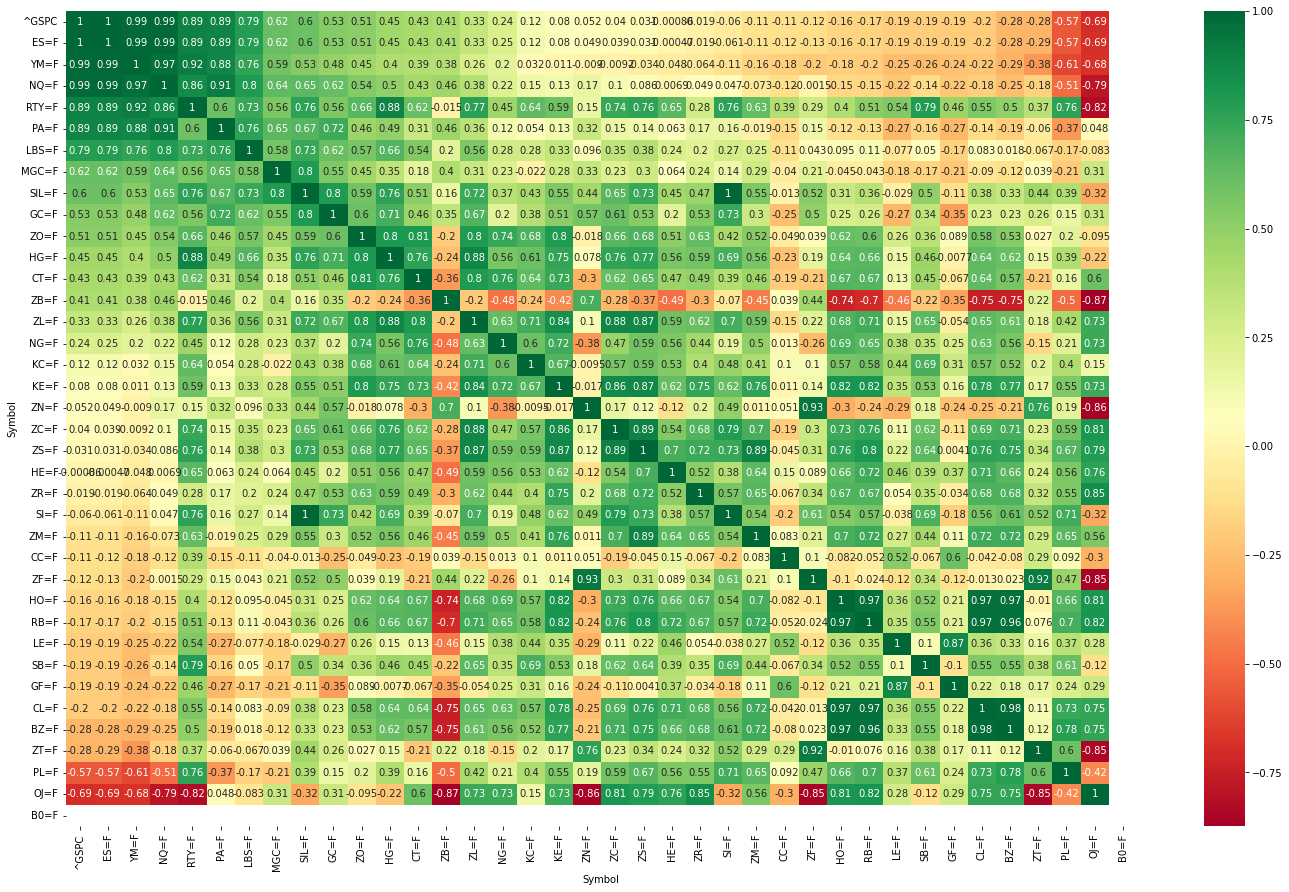

In [117]:
sorted_by_GSPC_future_commodities_corr = future_commodities_nSP500_pvt.corr()[['^GSPC']].sort_values(by='^GSPC',ascending=False)

import seaborn as sns

plt.figure(figsize=(24,15))
sns.heatmap(future_commodities_nSP500_pvt[sorted_by_GSPC_future_commodities_corr.index].corr(),cmap="RdYlGn",annot=True)
plt.savefig('..\\reports\\figures\\'+end.strftime('%Y-%m-%d')+'_sorted_by_GSPC_future_commodities_corr.png', dpi=300, format='png', bbox_inches='tight')
plt.show()


In [99]:
trending = pd.DataFrame((future_commodities_nSP500_pvt['^GSPC']-future_commodities_nSP500_pvt['^GSPC'].shift(40))>0)
trending.columns = ['trending']

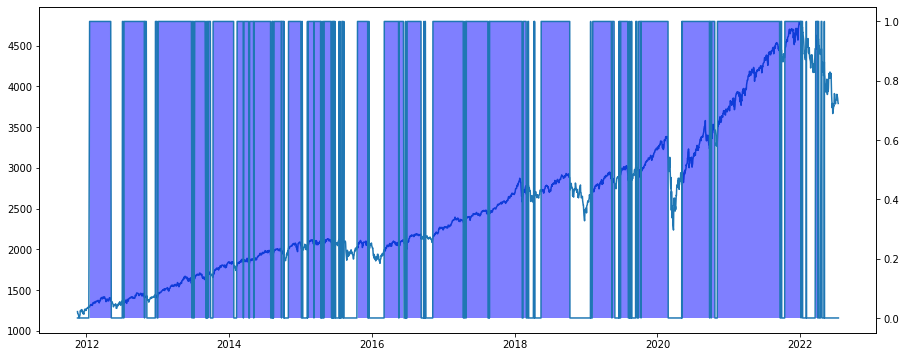

In [134]:
fig, ax1 = plt.subplots( figsize=(15,6) )

ax2 = ax1.twinx()

ax1.plot(trending_df[['^GSPC']])
ax2.plot(trending_df[['trending']])
ax2.fill_between(trending_df.index, 0, 1, where=trending_df['trending'] == True,facecolor='blue', alpha=0.5)
plt.savefig('..\\reports\\figures\\'+end.strftime('%Y-%m-%d')+'_SP500_trending.png', dpi=300, format='png', bbox_inches='tight')


In [103]:
trending_df = pd.concat([future_commodities_nSP500_pvt,trending],axis=1)
future_commodities_trending = trending_df[trending_df['trending']==True]
future_commodities_not_trending = trending_df[trending_df['trending']!=True]

correlations when trending
1922


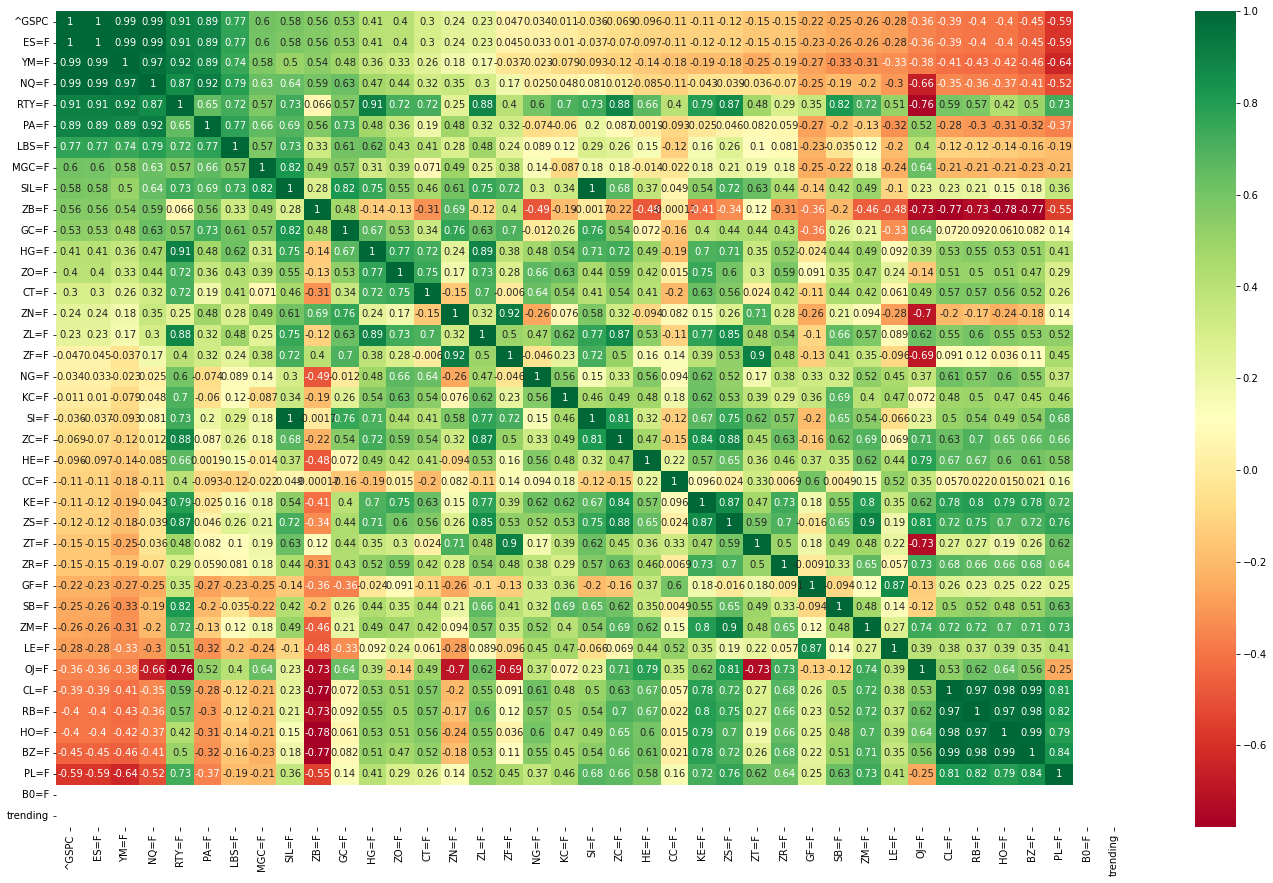

In [135]:
print("correlations when trending")
print(len(future_commodities_trending))

sorted_future_commodities_trending = future_commodities_trending.corr()[['^GSPC']].sort_values(by='^GSPC',ascending=False)

import seaborn as sns

plt.figure(figsize=(24,15))
sns.heatmap(future_commodities_trending[sorted_future_commodities_trending.index].corr(),cmap="RdYlGn",annot=True)
plt.savefig('..\\reports\\figures\\'+end.strftime('%Y-%m-%d')+'_sorted_by_GSPC_future_commodities_trending_corr.png', dpi=300, format='png', bbox_inches='tight')
plt.show()

correlations when not trending
761


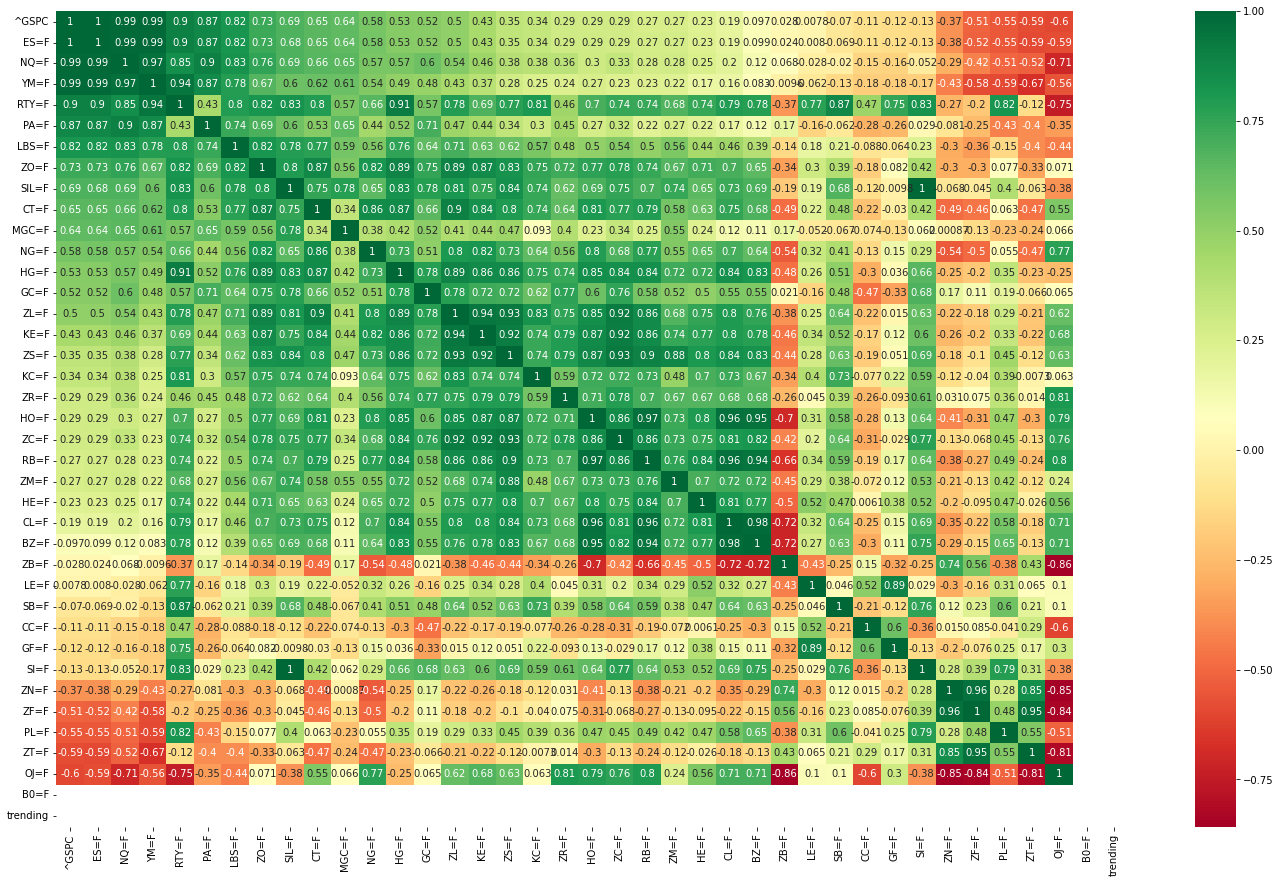

In [136]:
print("correlations when not trending")
print(len(future_commodities_not_trending))

sorted_future_commodities_not_trending = future_commodities_not_trending.corr()[['^GSPC']].sort_values(by='^GSPC',ascending=False)

import seaborn as sns

plt.figure(figsize=(24,15))
sns.heatmap(future_commodities_not_trending[sorted_future_commodities_not_trending.index].corr(),cmap="RdYlGn",annot=True)
plt.savefig('..\\reports\\figures\\'+end.strftime('%Y-%m-%d')+'_sorted_by_GSPC_future_commodities_not_trending_corr.png', dpi=300, format='png', bbox_inches='tight')
plt.show()

In [22]:
#test

import pandas as pd
import datetime as dt
dates = []
for d in pd.read_csv('..\\data\\raw\\sample.csv')['Date']:
    dates.append(dt.datetime.strptime(d, '%d-%b-%y'))

temp = pd.read_csv('..\\data\\raw\\sample.csv',thousands=",")
temp.index = dates
temp = temp.iloc[:,1:]
temp.columns = ['Open','High','Low','Adj Close','Volume']
#temp['Close'] = temp['Close'].astype(float)
temp.sort_index(inplace=True)
temp['Symbol'] = 'Test'

temp_new = derive_price_supply_trends(['temp',temp,nyse_dates]).sort_index(ascending=False)
print(temp_new)
print(calculateMetrics(temp_new))
#


               Open     High      Low  Adj Close     Volume Symbol  \
2022-05-25  3929.59  3999.33  3925.03    3978.73   100000.0   temp   
2022-05-24  3942.94  3955.68  3875.13    3941.48   200000.0   temp   
2022-05-23  3919.42  3981.88  3909.04    3973.75   300000.0   temp   
2022-05-20  3927.76  3943.42  3810.32    3901.36   400000.0   temp   
2022-05-19  3899.00  3945.96  3876.58    3900.79   500000.0   temp   
...             ...      ...      ...        ...        ...    ...   
2017-10-09  2551.39  2551.82  2541.60    2544.73  1500000.0   temp   
2017-10-06  2547.44  2549.41  2543.79    2549.33  1600000.0   temp   
2017-10-05  2540.86  2552.51  2540.02    2552.07  1700000.0   temp   
2017-10-04  2533.48  2540.53  2531.80    2537.74  1800000.0   temp   
2017-10-03  2530.34  2535.13  2528.85    2534.58  1900000.0   temp   

            trailing_1yr_max  MIN_Lookback_One_Year  MIN_Lookback_2_Months  \
2022-05-25           4818.62                4238.04                4818.62   
202

In [23]:
npa = []
for i in range(0,len([*SP1500,*indexes,*sectors])):
    npa.append([[*SP1500,*indexes,*sectors][i],start.strftime('%Y-%m-%d'),end.strftime('%Y-%m-%d')])
    
# = getStock(npa[0])
    
client = Client('192.168.3.100:8786')
#client = Client(n_workers=4,threads_per_worker=1)
client.restart()
future = client.map(getStock, npa)
results_prices = []
#my intent was to capture future objects vs results and this gave me results
for f in as_completed(future):
    if(f.status=="error"):
        results_prices.append("error")
    else:
        results_prices.append(f.result()) 
client.close()


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\distributed\client.py:1265: VersionMismatchWarning: Mismatched versions found

+-------------+---------------+---------------+---------------+
| Package     | client        | scheduler     | workers       |
+-------------+---------------+---------------+---------------+
| dask        | 2022.01.1     | 2021.11.2     | 2021.11.2     |
| distributed | 2022.01.1     | 2021.11.2     | 2021.11.2     |
| lz4         | 3.1.3         | 3.1.10        | 3.1.10        |
| python      | 3.9.7.final.0 | 3.9.9.final.0 | 3.9.9.final.0 |
| toolz       | 0.11.1        | 0.11.2        | 0.11.2        |
+-------------+---------------+---------------+---------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


In [24]:
npa = []
for i in range(0,len([*SP1500,*indexes,*sectors])):
    npa.append([[*SP1500,*indexes,*sectors][i]])

client = Client('192.168.3.100:8786')
#client = Client(n_workers=4,threads_per_worker=1)
client.restart()

future = client.map(getTickerData, npa)

results_ticker_data = []

#my intent was to capture future objects vs results and this gave me results
for f in as_completed(future):
    if(f.status=="error"):
        results_ticker_data.append("error")
    else:
        results_ticker_data.append(f.result()) 
#client.restart()
client.close()


In [25]:
print(results_ticker_data[0][1].info)
print(results_ticker_data[0][1].quarterly_balance_sheet)
print(results_ticker_data[0][1].quarterly_cashflow)
#print(results_ticker_data[0][1].quarterly_dividends)
print(results_ticker_data[0][1].quarterly_earnings)
print(results_ticker_data[0][1].quarterly_financials)


{'zip': '80237', 'sector': 'Consumer Cyclical', 'fullTimeEmployees': 2080, 'longBusinessSummary': 'M.D.C. Holdings, Inc., through its subsidiaries, engages in the homebuilding and financial service businesses. Its homebuilding operations include purchasing finished lots or developing lots for the construction and sale primarily of single-family detached homes to first-time and first-time move-up homebuyers under the Richmond American Homes name. The company conducts its homebuilding operations in Arizona, California, Nevada, New Mexico, Oregon, Texas, Washington, Colorado, Idaho, Utah, Maryland, Pennsylvania, Virginia, Tennessee, and Florida. Its financial services operations comprise originating mortgage loans primarily for homebuyers; providing insurance coverage primarily to its homebuilding subsidiaries and subcontractors for homes sold by its homebuilding subsidiaries, and for work performed in completed subdivisions; acting as a re-insurer on the claims; selling third-party perso

In [26]:
results_ticker_data[0][1].info

{'zip': '80237',
 'sector': 'Consumer Cyclical',
 'fullTimeEmployees': 2080,
 'longBusinessSummary': 'M.D.C. Holdings, Inc., through its subsidiaries, engages in the homebuilding and financial service businesses. Its homebuilding operations include purchasing finished lots or developing lots for the construction and sale primarily of single-family detached homes to first-time and first-time move-up homebuyers under the Richmond American Homes name. The company conducts its homebuilding operations in Arizona, California, Nevada, New Mexico, Oregon, Texas, Washington, Colorado, Idaho, Utah, Maryland, Pennsylvania, Virginia, Tennessee, and Florida. Its financial services operations comprise originating mortgage loans primarily for homebuyers; providing insurance coverage primarily to its homebuilding subsidiaries and subcontractors for homes sold by its homebuilding subsidiaries, and for work performed in completed subdivisions; acting as a re-insurer on the claims; selling third-party pe

In [27]:
npa = []
results_ticker_names = [r[0] for r in results_ticker_data]
for n in range(0,len(results_ticker_names),1):
    npa.append([results_ticker_names[n],results_ticker_data[n][1]])

In [28]:

client = Client('192.168.3.100:8786')
#client = Client(n_workers=4,threads_per_worker=1)
client.restart()

future = client.map(extractTickerValues, npa)

results_ticker_values = []

#my intent was to capture future objects vs results and this gave me results
for f in as_completed(future):
    if(f.status=="error"):
        results_ticker_values.append("error")
    else:
        results_ticker_values.append(f.result()) 
client.close()

"""
trackers = ['beta','currentRatio','debtToEquity','dividendRate','dividendYield','earningsGrowth','ebitda','ebitdaMargins','forwardPE','freeCashflow','grossMargins','grossProfits','heldPercentInstitutions','industry','marketCap','operatingCashflow','operatingMargins','payoutRatio','pegRatio','priceToBook','priceToSalesTrailing12Months','profitMargins','quickRatio','returnOnAssets','returnOnEquity','revenueGrowth','revenuePerShare','sector','sharesOutstanding','shortRatio','totalAssets','totalCash','totalCashPerShare','totalDebt','totalRevenue','trailingPE']

for t in trackers:
    if(np.sum(np.where(subset.columns==t))==0):
        values = pd.concat([values,pd.DataFrame('error',index=[n_],columns=[t])],axis=1)
    else:
        values = pd.concat([values,pd.DataFrame(subset[t].values[0],index=[n_],columns=[t])],axis=1)
"""

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\distributed\client.py:1265: VersionMismatchWarning: Mismatched versions found

+-------------+---------------+---------------+---------------+
| Package     | client        | scheduler     | workers       |
+-------------+---------------+---------------+---------------+
| dask        | 2022.01.1     | 2021.11.2     | 2021.11.2     |
| distributed | 2022.01.1     | 2021.11.2     | 2021.11.2     |
| lz4         | 3.1.3         | 3.1.10        | 3.1.10        |
| python      | 3.9.7.final.0 | 3.9.9.final.0 | 3.9.9.final.0 |
| toolz       | 0.11.1        | 0.11.2        | 0.11.2        |
+-------------+---------------+---------------+---------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


"\ntrackers = ['beta','currentRatio','debtToEquity','dividendRate','dividendYield','earningsGrowth','ebitda','ebitdaMargins','forwardPE','freeCashflow','grossMargins','grossProfits','heldPercentInstitutions','industry','marketCap','operatingCashflow','operatingMargins','payoutRatio','pegRatio','priceToBook','priceToSalesTrailing12Months','profitMargins','quickRatio','returnOnAssets','returnOnEquity','revenueGrowth','revenuePerShare','sector','sharesOutstanding','shortRatio','totalAssets','totalCash','totalCashPerShare','totalDebt','totalRevenue','trailingPE']\n\nfor t in trackers:\n    if(np.sum(np.where(subset.columns==t))==0):\n        values = pd.concat([values,pd.DataFrame('error',index=[n_],columns=[t])],axis=1)\n    else:\n        values = pd.concat([values,pd.DataFrame(subset[t].values[0],index=[n_],columns=[t])],axis=1)\n"

In [29]:
import pickle

ticker_values = pd.DataFrame()

pickle_dumps = []

for r in results_ticker_values:
    if(r=='error'):
        pass
        #pd.DataFrame(np.repeat('error', len(trackers), axis = None),index=)
    else:                
        #print(r[1])
        subset = pd.DataFrame(r[1])
        subset.index = [r[0]]
        #print(subset)
        ticker_values = pd.concat([ticker_values,subset],axis=0)
        pickle_dumps.append([r[0],r[2]])
        #ticker_values = pd.concat([ticker_values,pd.DataFrame(r[1],index=[r[0]])],axis=0)

pd.DataFrame(ticker_values)

pickle.dump(pickle_dumps, open('..\\data\\interim\\fundamental.pkl', 'wb'))

In [30]:
"""
missing_ticker_values = list(set([*SP1500,*indexes,*sectors]).difference([n for n in pd.DataFrame(ticker_values).index]))
print(missing_ticker_values)

for r in range(0,len(missing_ticker_values)):
    r_ = missing_ticker_values[r]
    temp = pd.DataFrame(np.array([r_,*np.repeat('missing',len(pd.DataFrame(ticker_values.columns)))])).T.set_index(0)
    temp.columns = ticker_values.columns
    #.set_index(0).iloc[[0]].columns))])
    ticker_values = pd.concat([ticker_values,temp],axis=0)
"""


"\nmissing_ticker_values = list(set([*SP1500,*indexes,*sectors]).difference([n for n in pd.DataFrame(ticker_values).index]))\nprint(missing_ticker_values)\n\nfor r in range(0,len(missing_ticker_values)):\n    r_ = missing_ticker_values[r]\n    temp = pd.DataFrame(np.array([r_,*np.repeat('missing',len(pd.DataFrame(ticker_values.columns)))])).T.set_index(0)\n    temp.columns = ticker_values.columns\n    #.set_index(0).iloc[[0]].columns))])\n    ticker_values = pd.concat([ticker_values,temp],axis=0)\n"

In [31]:
market_data = pd.concat([ticker_values])

In [32]:
names_prices = [rp[0] for rp in results_prices]

#def process_df(data_):
npa = []    
for n in range(0,len(names_prices)):
    #print(names_prices[n])
    n_ = names_prices[n]
    npa.append([n_,results_prices[n][1],nyse_dates])
    
    
prices_df = pd.DataFrame()

client = Client('192.168.3.100:8786')
#client = Client(n_workers=4,threads_per_worker=1)
client.restart()

future = client.map(derive_price_supply_trends, npa)
#results_sectors = []
#my intent was to capture future objects vs results and this gave me results
for f in as_completed(future):
    if(f.status=="error"):
        #results_sectors.append("error")
        pass
    else:
        #results_sectors.append(f.result())
        prices_df = pd.concat([f.result(),prices_df],axis=0)
client.close()

In [33]:

npa = []
for s in names_prices:
    #print(s)
    subset = prices_df.iloc[np.where(prices_df['Symbol']==s)]
    if(len(subset)==0):
        pass
    else:
        npa.append(subset)

screenerMetrics = []

client = Client('192.168.3.100:8786')
#client = Client(n_workers=4,threads_per_worker=1)
client.restart()

future = client.map(calculateMetrics, npa)

#my intent was to capture future objects vs results and this gave me results
for f in as_completed(future):
    if(f.status=="error"):
        screenerMetrics.append("error")
    else:
        screenerMetrics.append(f.result()) 
client.close()



In [34]:
screener_metrics = pd.concat(screenerMetrics)

In [35]:

missing_screener_metrics = list(set([*SP1500,*indexes,*sectors]).difference([n for n in screener_metrics.index]))
print(missing_screener_metrics)

for r in range(0,len(missing_screener_metrics)):
    r_ = missing_screener_metrics[r]
    test = pd.DataFrame([np.repeat('missing',len(screener_metrics.columns))],index=[r_],columns=screener_metrics.columns)
    screener_metrics = pd.concat([screener_metrics,test],axis=0)

#pd.DataFrame(screener_metrics)

['JW-A']


In [36]:
#fundamentals_quarterlies = pickle.load(open('./fundamental.pkl', 'rb'))
fundamental_entries = [e[0] for e in pickle_dumps]#[e[0] for e in fundamentals_quarterlies]


In [37]:
#summary = pd.concat([prices_df[prices_df['Symbol']==name_][['Symbol','MIN_Lookback_One_Year', 'MIN_Lookback_2_Months', 'MIN_Lookback_1_Months','risk_trend_factor','risk_per_share','volume_factor']].iloc[[-1]].reset_index().set_index('Symbol') for name_ in np.unique(prices_df['Symbol'].values)]).reset_index()

In [38]:


sector_performance = []
for v in sectors:
    sector_performance.append([v,screener_metrics.loc[[v]]['risk_trend_factor'].values[0]])
temp_v = pd.concat([pd.DataFrame([dict_sectors_reverse[v] for v in sectors]),pd.DataFrame(sectors)],axis=1)
temp_v.columns = ['Sector','Symbol']
sectors_risk_sorted = pd.DataFrame(sector_performance,columns=['Symbol','risk_trend_factor']).merge(temp_v, on='Symbol', how='left').sort_values(by='risk_trend_factor',ascending=False)    
sectors_risk_sorted

,Symbol,risk_trend_factor,Sector
3,VDE,-1.114742,Energy
10,VPU,-1.267262,Utilities
2,VDC,-2.488215,Consumer Defensive
5,VHT,-3.019525,Healthcare
8,VAW,-3.282134,Basic Materials
9,VNQ,-5.028486,Real Estate
6,VIS,-5.554051,Industrials
4,VFH,-5.692130,Financial Services
7,VGT,-6.166308,Technology
1,VCR,-8.056900,Consumer Cyclical


In [39]:
index_performance = []
for v in indexes:
    index_performance.append([v,screener_metrics.loc[[v]]['risk_trend_factor'].values[0]])
temp_i = pd.DataFrame(index_performance,index=indexes)
temp_i.columns = ['Symbol','risk_trend_factor']
index_risk_sorted = pd.DataFrame(index_performance,columns=['Symbol','risk_trend_factor'],index=indexes).sort_values(by='risk_trend_factor',ascending=False).reset_index()
index_risk_sorted.columns = ['Index','Symbol','risk_trend_factor']
index_risk_sorted

,Index,Symbol,risk_trend_factor
0,SPY,SPY,-4.779267
1,SPTM,SPTM,-4.906627
2,SLY,SLY,-5.705929
3,MDYG,MDYG,-6.145389


In [40]:

threshold = 0
#stock_fundamentals = market_data
#screener = screener_metrics
#stock_indexes = sp1500_index_df


#spdr_indexes = indexes
#spdr_indexes.columns=['Symbol']
#vanguard_sectors = sectors
#vanguard_sectors.columns=['Symbol']
screener_metrics_w_sp1500index = screener_metrics.reset_index().rename(columns={'index': 'Symbol'}).merge(sp1500_index_df,on='Symbol',how='left')

screener_metrics_w_sp1500index_good = screener_metrics_w_sp1500index[screener_metrics_w_sp1500index['risk_trend_factor']!='missing']

risk_trend_threshold = screener_metrics_w_sp1500index_good['risk_trend_factor'].quantile(q=[threshold]).values[0]
stock_sectors = market_data['sector']

temp = stock_sectors.reset_index()
temp.columns = ['Symbol','Sector']
sector_merged = screener_metrics.reset_index().rename(columns={'index': 'Symbol'}).merge(temp, on='Symbol', how='right')
temp_sm = sector_merged.merge(sp1500_index_df, on='Symbol', how='left').set_index('Symbol')
#temp_sm.columns = ['risk_trend_factor', 'Sector', 'index']

temp_index_symbol_map = pd.concat([sp1500_index_df,pd.DataFrame([invert_dict_indexes[s] for s in sp1500_index_df['Market Index']])],axis=1)
temp_index_symbol_map.columns = ['Symbol','Market Index','Index Symbol']

index_sector_merged = temp_sm.merge(temp_index_symbol_map.iloc[:,[0,2]], on='Symbol', how='left')

"""
for spdr_ in range(0,len(indexes)):
    spdr__ = indexes[spdr_]
    #spdr__i = indexes[spdr_]
    #temp_sm.iloc[np.where(temp_sm.index==spdr__)][['index']] = spdr__i
    temp_sm.iloc[np.where(temp_sm.index==spdr__)][['index_Symbol']] = spdr__
    """

"\nfor spdr_ in range(0,len(indexes)):\n    spdr__ = indexes[spdr_]\n    #spdr__i = indexes[spdr_]\n    #temp_sm.iloc[np.where(temp_sm.index==spdr__)][['index']] = spdr__i\n    temp_sm.iloc[np.where(temp_sm.index==spdr__)][['index_Symbol']] = spdr__\n    "

In [41]:
risk_screened = screener_metrics_w_sp1500index_good[(screener_metrics_w_sp1500index_good['risk_trend_factor']>risk_trend_threshold) & (screener_metrics_w_sp1500index_good['volume_factor']!= 'missing')]
risk_screened = risk_screened.merge(temp, on='Symbol', how='left')
print(risk_screened.columns)
#temp_df = risk_screened[['Symbol','Adj Close','MIN_Lookback_One_Year', 'MIN_Lookback_2_Months', 'MIN_Lookback_1_Months','risk_trend_factor','volume_factor','adf','hurst','Sector','Market Index']]
#temp_df.set_index('Symbol',inplace=True)
#pd.concat([temp_df,temp_sm],axis=0)

#screened_final_set = risk_screened

Index(['Symbol', 'Date', 'MIN_Lookback_One_Year', 'MIN_Lookback_2_Months',
       'MIN_Lookback_1_Months', 'risk_trend_factor', 'risk_per_share',
       'volume_factor', 'Adj Close', '21dBOLD', '21dMA-TP', '21dBOLU',
       '90dSMA', '90dSDev', 'adf', 'hurst', 'Market Index', 'Sector'],
      dtype='object')


In [42]:
threshold_value = screener_metrics_w_sp1500index_good.dropna()['risk_trend_factor'].quantile([threshold])

In [43]:
risk_trend_factor_sector_dict = dict()
for s in sectors:
    risk_trend_factor_sector_dict[s] = screener_metrics.loc[[s]]['risk_trend_factor'].values[-1]
    
risk_trend_factor_sector_dict['error']='error'

In [44]:
"""
inv_dict_map = {v: k for k, v in dict_indexes.items()}
inv_dict_map[np.nan] = 'error'
in_ = [inv_dict_map[t[0]] for t in temp_sm[['Market Index']].values]
se_ = [dict_sectors[t[0]] for t in temp_sm[['Sector']].values]
#temp_sm[['Sector','index']]
"""
#symbols_w_index_sector = pd.concat([pd.DataFrame(se_,columns=['index'],index=temp_sm.index),pd.DataFrame(in_,columns=['sector'],index=temp_sm.index)],axis=1)


"\ninv_dict_map = {v: k for k, v in dict_indexes.items()}\ninv_dict_map[np.nan] = 'error'\nin_ = [inv_dict_map[t[0]] for t in temp_sm[['Market Index']].values]\nse_ = [dict_sectors[t[0]] for t in temp_sm[['Sector']].values]\n#temp_sm[['Sector','index']]\n"

In [45]:
#symbols_w_index_sector

In [46]:
index_sector_merged

,Symbol,Date,MIN_Lookback_One_Year,MIN_Lookback_2_Months,MIN_Lookback_1_Months,risk_trend_factor,risk_per_share,volume_factor,Adj Close,21dBOLD,21dMA-TP,21dBOLU,90dSMA,90dSDev,adf,hurst,Sector,Market Index,Index Symbol
0,MDC,2022-07-14 00:00:00,56.529999,56.529999,56.529999,-5.87698,10.730001,1.303938,35.509998,27.358756,32.250159,37.141561,35.298981,2.818873,0.435581,0.462049,Consumer Cyclical,SP600,SLY
1,IPGP,2022-07-14 00:00:00,220.509995,220.509995,220.509995,-16.077245,23.949997,2.354695,92.160004,87.081206,92.818611,98.556017,97.153611,4.838568,0.368855,0.50486,Technology,SP400,MDYG
2,SPTM,2022-07-14 00:00:00,54.040001,59.080002,59.080002,-4.906627,6.639999,1.628213,46.540001,45.234116,46.724643,48.21517,49.293135,2.517049,0.683227,0.443932,error,NaN,NaN
3,HVT,2022-07-14 00:00:00,41.880001,41.880001,41.880001,-7.713031,6.83,0.90586,24.32,22.995059,24.534325,26.073592,26.12626,1.48883,0.592855,0.52366,Consumer Cyclical,SP600,SLY
4,NFG,2022-07-14 00:00:00,55.220001,74.32,75.970001,-1.079485,13.210003,1.2541,63.75,63.562402,65.981667,68.400933,69.39504,3.213123,0.828746,0.45113,Energy,SP400,MDYG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1510,KMX,2022-07-14 00:00:00,138.770004,155.979996,155.979996,-9.729443,18.849998,1.29191,89.110001,85.201038,91.542659,97.88428,92.990913,3.981357,0.401632,0.486954,Consumer Cyclical,SP500,SPY
1511,ENPH,2022-07-14 00:00:00,229.039993,282.459991,282.459991,-3.131453,64.889999,0.888057,196.919998,175.881262,193.878293,211.875324,180.701031,19.035376,0.798616,0.394773,Technology,SP500,SPY
1512,CCI,2022-07-14 00:00:00,203.970001,209.869995,209.869995,-2.749068,40.25,1.006008,171.020004,156.73623,167.783532,178.830834,177.311896,10.134699,0.709352,0.290605,Real Estate,SP500,SPY
1513,INTU,2022-07-14 00:00:00,511.690002,716.859985,716.859985,-10.694093,75.350006,1.171662,379.869995,361.83667,389.119603,416.402536,400.213262,32.708735,0.619126,0.521474,Technology,SP500,SPY


In [47]:
#pd.DataFrame([dict_sectors[s] for s in index_sector_merged['Sector']],columns=['Sector Symbol'],index=index_sector_merged['Symbol']
sector_symbols = pd.DataFrame([dict_sectors[s] for s in index_sector_merged['Sector']],index=index_sector_merged['Symbol'],columns=['Sector Symbol'])

symbols_w_sector_rtf = pd.DataFrame([risk_trend_factor_sector_dict[s] for s in sector_symbols['Sector Symbol']],columns=['sector_risk_trend_factor'],index=sector_symbols.index)

#screener_final = pd.concat([screener_metrics,symbols_w_index_sector.set_index),symbols_w_sector_rtf,index_sector_merged[['Market Index','Sector']]],axis=1)



In [48]:
screener_final = pd.concat([screener_metrics,symbols_w_sector_rtf,index_sector_merged.set_index('Symbol')[['Sector']],sector_symbols,index_sector_merged.set_index('Symbol')[['Market Index','Index Symbol']]],axis=1)

a = screener_final[screener_final['risk_trend_factor'].apply(type) != np.str_].sort_values(by='risk_trend_factor',ascending=False)
b = screener_final[screener_final['risk_trend_factor'].apply(type) == np.str_]
screener_sorted = pd.concat([a,b],axis=0)

In [49]:
#pd.concat([screener_metrics.sort_values(by='risk_trend_factor',ascending=False).iloc[:,1:],symbols_w_index_sector,symbols_w_sector_rtf,temp_sm[['Market Index','Sector']]],axis=1)

In [50]:
list_sector_n_indexes = []
list_stocks = []
for i in index_risk_sorted['Symbol'].values:
    list_sector_n_indexes.append(i)
for i in sectors_risk_sorted['Symbol'].values:
    list_sector_n_indexes.append(i)
#for i in screened_final_set['Symbol'].values:
for i in sp1500_index_df['Symbol'].values:
    list_stocks.append(i)
stocks_ = list_stocks
#stocks_ = np.unique(list_stocks, return_index=True)[1]
#list__ = [list_[symbol] for symbol in sorted(stocks_)]
#list__ = ['MCK','MPC','APA','LNTH','MUSA','CIVI','VAW','VGT','EQT','XOM','DVN','MRO','EOG','HES','CEIX','SM','RRC','MUR','MTDR','PXD','OXY','PDCE','NFG','FANG','TWI','PBF','MANT','HRB','VDC','ACC','GO','TVTY','FCN','VIVO']

In [51]:
#screener_sorted.head(50)

In [52]:
"""
rick_screener_final = rick_screener.dropna()[rick_screener.dropna()['risk_trend_factor'].values > threshold_value.values[0]]
rick_screener_final = pd.concat([rick_screener,rick_screener_final],axis=0).drop_duplicates(keep='last')

diff_ = np.setdiff1d(np.array([*list_sector_n_indexes,*stocks_]),rick_screener_final.index)

for d in diff_:
    rick_screener_final = pd.concat([rick_screener_final,pd.DataFrame([np.repeat(np.nan, len(rick_screener_final.columns))],columns=rick_screener_final.columns,index=[d])],axis=0)
    
rick_screener_final.loc[np.setdiff1d([*rick_screener_final.index],list_sector_n_indexes)].sort_values(by='risk_trend_factor',ascending=False).to_csv('rick_screener_final.csv')
"""
#screener_sorted.loc[np.setdiff1d([*screener_final.index],list_sector_n_indexes)].head(50)
screener_sorted.to_csv('..\\data\\processed\\'+end.strftime('%Y-%m-%d')+'_screener_sorted.csv')
screener_sorted.to_csv('..\\data\\processed\\screener_sorted.csv')

In [53]:
#screener_final.loc[np.setdiff1d([*screener_final.index],list_sector_n_indexes)]['risk_trend_factor']

In [54]:

npa = []
for f in FRED_Indicators:
    npa.append([f,start.strftime('%Y-%m-%d'),end.strftime('%Y-%m-%d'),nyse_dates])
    


In [55]:

completed_fred = pd.DataFrame()

client = Client('192.168.3.100:8786')
#client = Client(n_workers=4,threads_per_worker=1)
client.restart()

future = client.map(Fred_Data, npa)

#my intent was to capture future objects vs results and this gave me results
for f in as_completed(future):
    if(f.status=="error"):
        pass
    else:
        completed_fred = pd.concat([completed_fred,f.result()],axis=0)
client.close()

completed_fred_pvt = pd.pivot_table(completed_fred, values=['Value'], index=completed_fred.index,columns=['Symbol'])
completed_fred_pvt

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\distributed\client.py:1265: VersionMismatchWarning: Mismatched versions found

+-------------+---------------+---------------+---------------+
| Package     | client        | scheduler     | workers       |
+-------------+---------------+---------------+---------------+
| dask        | 2022.01.1     | 2021.11.2     | 2021.11.2     |
| distributed | 2022.01.1     | 2021.11.2     | 2021.11.2     |
| lz4         | 3.1.3         | 3.1.10        | 3.1.10        |
| python      | 3.9.7.final.0 | 3.9.9.final.0 | 3.9.9.final.0 |
| toolz       | 0.11.1        | 0.11.2        | 0.11.2        |
+-------------+---------------+---------------+---------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Value                                                   \
Symbol     ASPUS AWHAETP B432RG3A086NBEA BAA10Y BACDINA066MNFRBNY   
2017-03-16   NaN     NaN             NaN   2.21               NaN   
2017-03-17   NaN     NaN             NaN   2.22               NaN   
2017-03-20   NaN     NaN             NaN   2.23               NaN   
2017-03-21   NaN     NaN             NaN   2.23               NaN   
2017-03-22   NaN     NaN             NaN   2.23               NaN   
...          ...     ...             ...    ...               ...   
2022-07-11   NaN     NaN             NaN   2.32               NaN   
2022-07-12   NaN     NaN             NaN   2.31               NaN   
2022-07-13   NaN     NaN             NaN   2.32               NaN   
2022-07-14   NaN     NaN             NaN   2.31               NaN   
2022-07-15   NaN     NaN             NaN    NaN               NaN   

                                                                       \
Symbol     BACTSAMFRBDAL BAMLC0A0CM BAMLCC0A1AAATRIV BAMLCC0A4BBBTRIV   
2017-03-16           NaN       1.22           589.00           768.87   
2017-03-17           NaN       1.22           590.41           770.01   
2017-03-20           NaN       1.22           592.09           771.52   
2017-03-21           NaN       1.22           593.91           773.32   
2017-03-22           NaN       1.23           596.21           774.83   
...                  ...        ...              ...              ...   
2022-07-11           NaN       1.58           666.49           861.93   
2022-07-12           NaN       1.59           668.00           863.21   
2022-07-13           NaN       1.59           671.59           864.66   
2022-07-14           NaN       1.60           668.75           861.76   
2022-07-15           NaN        NaN              NaN              NaN   

                        ...                                                  \
Symbol     BAMLH0A3HYC  ... VIXCLS VXVCLS  WDFUELLA    WGS3MO WILLLRGCAPVAL   
2017-03-16        8.29  ...  11.21  13.78       NaN       NaN      72081.66   
2017-03-17        8.35  ...  11.28  13.92  1.513000  0.750000      72020.98   
2017-03-20        8.47  ...  11.34  13.90  1.519429  0.758571      71906.60   
2017-03-21        8.52  ...  12.47  14.62  1.521571  0.761429      71198.84   
2017-03-22        8.71  ...  12.81  14.68  1.523714  0.764286      71275.70   
...                ...  ...    ...    ...       ...       ...           ...   
2022-07-11       11.81  ...  26.17  28.25       NaN       NaN     113953.73   
2022-07-12       11.86  ...  27.29  28.82       NaN       NaN     113393.07   
2022-07-13       11.88  ...  26.82  28.56       NaN       NaN     112816.02   
2022-07-14       11.95  ...  26.40  28.61       NaN       NaN     112028.20   
2022-07-15         NaN  ...    NaN    NaN       NaN       NaN           NaN   

                                                                
Symbol     WILLMICROCAPPR WPU0911 WPU101 WPUSI019011    WTB3MS  
2017-03-16       12398.08     NaN    NaN         NaN       NaN  
2017-03-17       12488.16     NaN    NaN         NaN  0.740000  
2017-03-20       12435.30     NaN    NaN         NaN  0.748571  
2017-03-21       12143.97     NaN    NaN         NaN  0.751429  
2017-03-22       12042.88     NaN    NaN         NaN  0.754286  
...                   ...     ...    ...         ...       ...  
2022-07-11       12956.97     NaN    NaN         NaN       NaN  
2022-07-12       12945.87     NaN    NaN         NaN       NaN  
2022-07-13       13002.51     NaN    NaN         NaN       NaN  
2022-07-14       12850.98     NaN    NaN         NaN       NaN  
2022-07-15            NaN     NaN    NaN         NaN       NaN  

[1344 rows x 145 columns]

In [56]:
npa = []
for e in etf_bonds:
    npa.append([e,start.strftime('%Y-%m-%d'),end.strftime('%Y-%m-%d'),nyse_dates])
    
completed_bonds = pd.DataFrame()

client = Client('192.168.3.100:8786')
#client = Client(n_workers=4,threads_per_worker=1)
client.restart()

future = client.map(dl, npa)

#my intent was to capture future objects vs results and this gave me resultsa
for f in as_completed(future):
    if(f.status=="error"):
        pass
    else:
        completed_bonds = pd.concat([completed_bonds,f.result()],axis=0)
client.close()

completed_bonds_pvt = pd.pivot_table(completed_bonds, values='Close', index=completed_bonds.index,columns=['Symbol'])
completed_bonds_pvt

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\distributed\client.py:1265: VersionMismatchWarning: Mismatched versions found

+-------------+---------------+---------------+---------------+
| Package     | client        | scheduler     | workers       |
+-------------+---------------+---------------+---------------+
| dask        | 2022.01.1     | 2021.11.2     | 2021.11.2     |
| distributed | 2022.01.1     | 2021.11.2     | 2021.11.2     |
| lz4         | 3.1.3         | 3.1.10        | 3.1.10        |
| python      | 3.9.7.final.0 | 3.9.9.final.0 | 3.9.9.final.0 |
| toolz       | 0.11.1        | 0.11.2        | 0.11.2        |
+-------------+---------------+---------------+---------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Symbol,AGG,AGZ,BIL,GBF,GOVT,IEF,IEI,ILTB,IMTB,ISTB,IUSB,LQD,MEAR,MUB,NEAR,SHV,SHY,SUB,TLT
2017-03-16,96.729584,103.515144,87.300537,101.788155,22.964396,97.017776,114.222267,51.388824,43.253513,45.154213,44.493198,101.764877,47.536732,97.878807,46.251743,104.661362,79.611320,99.901382,107.359444
2017-03-17,96.936226,103.441597,87.300537,101.924568,22.992104,97.277840,114.399796,51.780727,43.395550,45.172298,44.617619,102.000633,47.493881,97.933121,46.270164,104.661362,79.649055,99.910851,108.033287
2017-03-20,97.079979,103.653061,87.281425,102.233749,23.038294,97.510086,114.558693,51.797756,43.581989,45.181328,44.635395,102.236389,47.493881,98.059967,46.279369,104.670845,79.696259,99.920311,108.497704
2017-03-21,97.277641,103.827675,87.300537,102.415619,23.093721,97.835121,114.792351,52.181133,43.599747,45.217487,44.786503,102.489571,47.580521,98.286430,46.270164,104.670845,79.734024,99.996147,109.399147
2017-03-22,97.412422,103.827675,87.300537,102.461060,23.130676,98.020905,114.876457,52.445232,43.528725,45.226509,44.848717,102.751526,47.574818,98.404190,46.270164,104.670845,79.752884,100.034065,109.836266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-08,101.230003,109.690002,91.419998,106.949997,23.750000,101.489998,118.779999,55.080002,44.590000,47.299999,46.650002,110.349998,49.750000,106.650002,49.189999,110.019997,82.559998,104.709999,112.500000
2022-07-11,101.699997,110.019997,91.430000,107.379997,23.870001,102.290001,119.230003,55.529999,44.750000,47.330002,46.820000,110.660004,49.750000,106.849998,49.209999,110.000000,82.589996,104.820000,114.440002
2022-07-12,101.839996,109.910004,91.419998,107.699997,23.930000,102.529999,119.410004,55.680000,44.500000,47.340000,46.860001,110.820000,49.768002,107.110001,49.220001,109.989998,82.629997,104.809998,115.120003
2022-07-13,102.209999,110.000000,91.419998,108.059998,23.969999,102.970001,119.440002,56.240002,44.924999,47.299999,46.990002,111.650002,49.779999,107.230003,49.200001,109.970001,82.540001,104.790001,116.440002


In [57]:
#writer = pd.ExcelWriter('SP1500_screener_multiple.xlsx', engine='xlsxwriter')

data_object = [start,end,prices_df, sp1500_index_df, sp500, sp600, sp400, market_data, completed_fred_pvt, completed_bonds, completed_bonds_pvt, pd.DataFrame(sectors,sector_names), pd.DataFrame(indexes,index_names), screener_sorted, dict_sectors, dict_indexes, dict_sectors_reverse,invert_dict_indexes, list_sector_n_indexes, list_stocks]
               
pickle.dump(data_object, open('..\\data\\interim\\data_object.pkl', 'wb'))
"""
#prices_df.to_excel(writer, sheet_name='SP1500_Sectors_Indexes_Prices')
#prices_df.drop(['Sector', 'Market Cap'], axis=1).to_excel(writer, sheet_name='SP1500Prices')

#sectors_df.to_excel(writer, sheet_name='stock_sectors')

#mktcap_df.to_excel(writer, sheet_name='market_caps')

sp1500_index_df.to_excel(writer, sheet_name='SP1500')

pd.DataFrame(sp500).to_excel(writer, sheet_name='SP500')
pd.DataFrame(sp600).to_excel(writer, sheet_name='SP600')
pd.DataFrame(sp400).to_excel(writer, sheet_name='SP400')
pd.DataFrame(market_data).to_excel(writer, sheet_name='Stock_Fundamentals')
completed_fred_pvt.to_excel(writer, sheet_name='completed_fred_pvt')
completed_bonds.to_excel(writer, sheet_name='completed_bonds')
completed_bonds_pvt.to_excel(writer, sheet_name='completed_bonds_pvt')
pd.DataFrame(pd.DataFrame(sectors,sector_names)).to_excel(writer, sheet_name='vanguard_sectors')
pd.DataFrame(pd.DataFrame(indexes,index_names)).to_excel(writer, sheet_name='spdr_indexes')
screener_metrics.to_excel(writer, sheet_name='Screener')

writer.save()

wb = openpyxl.load_workbook('SP1500_screener_multiple.xlsx')
#openpyxl.Workbook()
new_range = openpyxl.workbook.defined_name.DefinedName('Prices', attr_text='SP1500_Sectors_Indexes_Prices!$A$1:$H$'+str(len(prices_df)+1))
wb.defined_names.append(new_range)
new_range = openpyxl.workbook.defined_name.DefinedName('SP1500', attr_text='SP1500!$B$1:$C$'+str(len(sp1500_index_df)+1))
wb.defined_names.append(new_range)
new_range = openpyxl.workbook.defined_name.DefinedName('Vanguard_Sectors', attr_text='vanguard_sectors!$B$1:$C$'+str(len(sectors)+1))
wb.defined_names.append(new_range)
new_range = openpyxl.workbook.defined_name.DefinedName('SPDR_Indexes', attr_text='spdr_indexes!$B$1:$C$'+str(len(indexes)+1))
wb.defined_names.append(new_range)


#wb.defined_names.append(new_range)
wb.save('SP1500_screener_multiple.xlsx')
wb.close()
#named_range = NamedRange("test_nr", [(new_sheet, "A1")])
#wb.add_named_range(new_range)
wb.close()
writer.close()
"""
"""
workbook = xlsxwriter.Workbook('SP1500_screener_multiple.xlsx')
workbook.define_name('Prices', '=SP1500Prices!$A$1:$J$'+str(len(prices_df)+1))
workbook.define_name('Sectors', '=stock_sectors!$A$1:$B$'+str(len(sectors_df)+1))
workbook.define_name('market_caps', '=market_caps!$A$1:$B$'+str(len(mktcap_df)+1))
workbook.define_name('SP1500', '=SP1500!$B$1:$C$'+str(len(sp1500_index_df)+1))

workbook.close()
"""

"\nworkbook = xlsxwriter.Workbook('SP1500_screener_multiple.xlsx')\nworkbook.define_name('Prices', '=SP1500Prices!$A$1:$J$'+str(len(prices_df)+1))\nworkbook.define_name('Sectors', '=stock_sectors!$A$1:$B$'+str(len(sectors_df)+1))\nworkbook.define_name('market_caps', '=market_caps!$A$1:$B$'+str(len(mktcap_df)+1))\nworkbook.define_name('SP1500', '=SP1500!$B$1:$C$'+str(len(sp1500_index_df)+1))\n\nworkbook.close()\n"